<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Chapter 5. Feature Selection</h2>

<a id='1.1'>
    <h2 style='font-size:180%;'>
        Mission</h2></a>

<figure>
    <blockquote cite='https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks?taskId=2729'>
        <p style='font-size:110%;
                  color:hsl(208, 12%, 30%);'><i>Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as non-churning will do. So recall needs to be higher. Till now, I have managed to get a recall of 62%.</i></p>
    </blockquote>
    <figcaption>—Sakshi Goyal, <cite>Credit Card Customers, Kaggle</cite></figcaption>

<a id='4.1'>
    <h2 style='font-size:180%;'>
        Libraries</h2></a>

In [1]:
# general
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from numpy import (mean, std)
from scipy.stats import (
    pearsonr, spearmanr, kendalltau,
    chi2_contingency, f_oneway)

# machine learning prep
from sklearn.preprocessing import (
    MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer)
from sklearn.feature_selection import RFE
from collections import Counter
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_predict,
    RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score, auc, roc_auc_score,
    precision_recall_curve, plot_precision_recall_curve, average_precision_score, precision_recall_fscore_support,
    classification_report, precision_recall_fscore_support, confusion_matrix, SCORERS, make_scorer)
from sklearn.pipeline import Pipeline

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import (SVC, LinearSVC) # remove SVC later if not used
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, 
    GradientBoostingClassifier, IsolationForest)
from sklearn.neural_network import MLPClassifier

# warning
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore', category=ConvergenceWarning)
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

# saving
import os

# efficiency
import time

In [2]:
# settings
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True, precision=3)

In [3]:
%%html
<style>
/* CSS styles for pandas dataframe */
.dataframe th {
    font-size: 16px;
}
.dataframe td {
    font-size: 14px;
}
</style>

In [4]:
# pd.set_options('precision', 3)
# pd.set_options('min_rows', 6)
# pd.set_options('max_rows', 10)
# pd.reset_option('max_rows')
# pd.set_option('max_colwidth', 10)
# pd.set_option("chop_threshold", 0.5)
# pd.reset_option("chop_threshold")
# pd.set_option("colheader_justify", "left")
# pd.reset_option("colheader_justify")
# plt.rc('figure',figsize=(8,4))
# plt.style.use('seaborn-whitegrid')
# from IPython.display import display, Math, Latex
# pio.renderers.default='plotly_mimetype'

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Data Loading</h2></a>

In [5]:
start_normal = time.perf_counter()

In [6]:
# load data
d = pd.read_csv('source/d_num.csv')
d.head(3)

,churn,age,gender,dependents,prod_ct,mo_on_book,mo_inactive_r12,contr_ct_r12,revbal_avg_r12,credlim_avg_r12,opentobuy_avg_r12,utilratio_avg,tx_amt_r12,tx_ct_r12,chng_tx_amt_q4_q1,chng_tx_ct_q4_q1,marstat_Divorced,marstat_Married,marstat_Single,marstat_Unknown,card_Blue,card_Gold,card_Platinum,card_Silver,educ,inc,tx_amt_pertx_r12
0,0,45,1,3,5,39,1,3,777.00,"12,691.00","11,914.00",0.06,"1,144.00",42,1.33,1.62,0,1,0,0,1,0,0,0,1,3,27.24
1,0,49,0,5,6,44,1,2,864.00,"8,256.00","7,392.00",0.10,"1,291.00",33,1.54,3.71,0,0,1,0,1,0,0,0,3,1,39.12
2,0,51,1,3,4,36,1,0,0.00,"3,418.00","3,418.00",0.00,"1,887.00",20,2.59,2.33,0,1,0,0,1,0,0,0,3,4,94.35


<a id='4.3'>
    <h2 style='font-size:180%;'>
        Train Test Split</h2></a>

In [7]:
d_values = d.values
x, y = d_values[:,1:], d_values[:,:1].ravel()

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Functions to Use</h2>

### Performance Metrics

In [8]:
def perf_metrics(y_test, y_pred):
    dic = {}
    dic['accuracy'] = round(accuracy_score(y_test, y_pred), 2)
    dic['precision'] = round(precision_score(y_test, y_pred), 2)
    dic['recall'] = round(recall_score(y_test, y_pred), 2)
    dic['f1'] = round(f1_score(y_test, y_pred), 2)
    dic['f2'] = round(fbeta_score(y_test, y_pred, beta=2), 2)
    return dic

### Result Summary

In [9]:
def result_rskf(x, y, pipeline, mod_disp_name, n_splits=5, n_repeats=3):
   
    # define cv method
    cv = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=1)  
    
    # define performance metrics
    scoring = {
        'accuracy':'accuracy', 'precision':'precision', 'recall':'recall', 'f1':'f1', 
        'f2':make_scorer(fbeta_score, beta=2)} # dict val = scorer fct or predefined metric str  
    
    # evaluate result
    result = cross_validate(
        pipeline, x, y, cv=cv, 
        scoring=scoring, return_train_score=True, n_jobs=-1)
        
    # make a summary table
    df = pd.DataFrame(
        (k, mean(v), std(v)) for k,v in result.items()
        ).rename({0:'metric', 1:'mean', 2:'std'}, axis=1
                ).set_index('metric')
    df.index.name = None
    df.columns = pd.MultiIndex.from_product([[mod_disp_name],df.columns])
    
    return df, result

In [10]:
def result_tts(x, y, pipeline, mod_disp_name):
    
    # define cv method
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)
    
    # evaluate result   
    time_0 = time.time()
    pipeline.fit(x_train, y_train)
    time_1 = time.time()
    y_pred = pipeline.predict(x_test)
    time_2 = time.time()
    result = {}
    result['fit_time'] = round(time_1-time_0, 2)
    result['score_time'] = round(time_2-time_1, 2)
    result['accuracy'] = round(accuracy_score(y_test, y_pred), 2)
    result['precision'] = round(precision_score(y_test, y_pred), 2)
    result['recall'] = round(recall_score(y_test, y_pred), 2)
    result['f1'] = round(f1_score(y_test, y_pred), 2)
    result['f2'] = round(fbeta_score(y_test, y_pred, beta=2), 2)
    conf_mat = confusion_matrix(y_test, y_pred, labels=[1,0])
    
    # make a summary table    
    df = pd.DataFrame(result, index=[mod_disp_name]).T
    
    return df, result, conf_mat, y_pred, y_test

In [11]:
def summary_by_mod(x, y, models, scalers, result_func=result_rskf, **n_splits_and_repeats):
    results = []
    time_0 = time.time() # for all methods in pipeline
    for scaler in scalers:
        results_models = []
        time_1 = time.time() # for each scaler
        print(f'Scaler: {scaler[0]}\n')
        for model in models:
            time_2 = time.time() # for each model
            pipeline = Pipeline([('s', scaler[1]), ('m', model[1])])
            if result_func==result_rskf:
                n_splits, n_repeats = (i for i in n_splits_and_repeats.values())
                results_model = result_func(x, y, pipeline, model[0], n_splits, n_repeats)[0]
            else:
                results_model = result_func(x, y, pipeline, model[0])[0]
            print(f'Model {model[0]} Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-time_2))}')
            results_models.append(results_model)
        print(f'Scaler {scaler[0]} Avg Runtime per Model: {time.strftime("%M:%S", time.gmtime((time.time()-time_1)/len(models)))}\n\n')
        results.append(results_models)
    print(f'Total Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-time_0))} min')
    return results

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Benchmark</h2>

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Baseline Models</h2></a>

In [12]:
# create a list of tuples for all models to explore: [(`model name`, `model instance`)] with minimum hyperparameter setting
models = []

# linear
models.append(('LR', LogisticRegression(solver='saga', max_iter=10000, class_weight='balanced', random_state=5))) # note: `max_iter` from 1000 to 10000 due to convergence issues
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))

# non-linear
models.append(('DT', DecisionTreeClassifier(random_state=5)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('MLP', MLPClassifier(max_iter=1000, random_state=5)))

# ensemble
models.append(('BDT', BaggingClassifier(n_estimators=50, n_jobs=-1, random_state=5)))
models.append(('RF', RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=5))) # note: increasing n_estimators more than 400 doesn't do much; some in place to prevent too much overfitting
models.append(('GB', GradientBoostingClassifier(random_state=5))) # note: `max_iter` from 100 to 1000 due to convergence issues

In [13]:
# create a list of tuples for all scalers to explore: [(`scaler name`, `scaler instance`)]
scalers = []
scalers.append(('RS', RobustScaler()))
scalers.append(('QT', QuantileTransformer()))

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Validation Set</h2></a>

In [15]:
results_bsl = summary_by_mod(x, y, models, scalers, result_func=result_rskf, n_splits=5, n_repeats=3)

Scaler: RS

Model LR Runtime: 00:15
Model LDA Runtime: 00:00
Model NB Runtime: 00:00
Model DT Runtime: 00:01
Model KNN Runtime: 00:32
Model MLP Runtime: 04:11
Model BDT Runtime: 00:18
Model RF Runtime: 00:05
Model GB Runtime: 00:24
Scaler RS Avg Runtime per Model: 00:39


Scaler: QT

Model LR Runtime: 00:02
Model LDA Runtime: 00:01
Model NB Runtime: 00:00
Model DT Runtime: 00:01
Model KNN Runtime: 00:21
Model MLP Runtime: 03:05
Model BDT Runtime: 00:18
Model RF Runtime: 00:05
Model GB Runtime: 00:17
Scaler QT Avg Runtime per Model: 00:28


Total Runtime: 10:06 min


In [16]:
results_bsl_RS = pd.concat([i for i in results_bsl[0]], axis=1)
results_bsl_QT = pd.concat([i for i in results_bsl[1]], axis=1)

<a id='4.2'>
    <h2 style='font-size:150%;'>
        Summary Baseline</h2></a>

In [17]:
print('Results for Robust Scaler:')
tem = results_bsl_RS.loc[['test_recall', 'test_precision', 'test_f2']]
df_RS_bsl_RS_summ = tem.loc[:,np.in1d(tem.columns.get_level_values(1), 'mean')].droplevel(level=1, axis=1).rename(
    index={'test_recall':'recall', 'test_precision':'prec', 'test_f2':'f2'}).T
df_RS_bsl_RS_summ

Results for Robust Scaler:


,recall,prec,f2
LR,0.86,0.54,0.77
LDA,0.64,0.78,0.66
NB,0.60,0.68,0.62
DT,0.81,0.81,0.81
KNN,0.64,0.87,0.67
MLP,0.82,0.85,0.83
BDT,0.85,0.91,0.86
RF,0.81,0.93,0.83
GB,0.85,0.93,0.86


In [18]:
print('Results for Quantile Transformer:')
tem = results_bsl_QT.loc[['test_recall', 'test_precision', 'test_f2']]
results_bsl_QT_summ = tem.loc[:,np.in1d(tem.columns.get_level_values(1), 'mean')].droplevel(level=1, axis=1).rename(
    index={'test_recall':'recall', 'test_precision':'prec', 'test_f2':'f2'}).T
results_bsl_QT_summ

Results for Quantile Transformer:


,recall,prec,f2
LR,0.86,0.53,0.77
LDA,0.62,0.77,0.65
NB,0.61,0.63,0.61
DT,0.81,0.81,0.81
KNN,0.52,0.81,0.56
MLP,0.83,0.86,0.83
BDT,0.85,0.91,0.86
RF,0.81,0.93,0.83
GB,0.85,0.93,0.86


<a id='4.2'>
    <h2 style='font-size:150%;'>
        Full Baseline</h2></a>

In [19]:
# results_bsl_RS

In [20]:
# results_bsl_QT

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Feature Selection</h2>

<a id='4.2'>
    <h2 style='font-size:240%;'>
        Overview</h2></a>

1. **Unsupervised** : Multicollinearity Treatment
    * Correlation - Spearman's & Kendall's
    * Variance Inflation Factor (VIF)
    * Analysis of Variance (ANOVA)


2. **Supervised** : Feature Selection
    * Intrinsic
    * Wrapper
    * Filter

<a id='4.2'>
    <h2 style='font-size:240%;'>
        Supervised</h2></a>

Unsupervised feature selection techniques ignore the target variable in selecting features. These techniques can be used to remove multicolinearity or redundancy. One of the most commonly used methods for removing multicolinearity is correlation.

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Multicollinearity</h2></a>

[Source: Statistics by Jim - Multicollinearity in Regression](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis)

Multicollinearity arises when the predictors in a regression are correlated. High correlation among features makes interpreting the model difficult because the model parameters become unstable which leads to higher standard error and lower p-values. 

The primary goal of regression analysis is to separate out the relationship between each predictor and the predictant. The parameters in the model represent the mean change in the predictant in response to one-unit change in the predictor in question *holding all other predictors constant*. This means that if two or more predictors are correlated, they have to move in the same direction at the same time making it impossible to "*[hold] all other predictors constant*". The stronger the correlation, the harder it is to change one predictor without changing the other. It becomes difficult for the model to estimate the *independent* effects of each predictor on the predictant as the predictors tend to change in unison.

There are two broad types of multicollinearity:

* Structural : Created, not inherent in the data itself
* Data : Inherent in the data itself, not created.

1. Correlation - useful for 2 variables
2. VIF - useful for 2+ variables
3. ANOVA - useful for 2+ variables

The variance inflation factor (VIF) uses the strength of the correlation between the predictors. Generally, the higher the VIF, the higher the level of collinearity. For example, a VIF of 1 is not collinear, but a VIF of 5 or above should be reduced to a single variable by either removal or transformation such as the PCA.

[Source: Towards Data Science - Multicollinearity in Data Science](https://towardsdatascience.com/multicollinearity-in-data-science-c5f6c0fe6edf)

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Problems of Multicollinearity</h2></a>

1. Uncertainty in coefficient estimates or unstable variance: Coefficients are sensitive to changes in the data (adding/removing rows/columns).
1. Increased standard error: Reduces the accuracy of the estimates and increases the chances of detection.
1. Decreased statistical significance: Due to increased standard error, t-statistic declines which negatively impacts the capability of detecting statistical significance in coefficient leading to type-II error (false negative).
1. Reducing coefficient & p-value: The importance of the correlated explanatory variable is masked due to collinearity.
1. Overfitting: Leads to overfitting as is indicated by the high variance problem.

One thing to note is that the unreliable coefficient estimates and p-values affect only those predictors that are correlated. It is possible to have a model with severe multicollinearity where some variables are completely unaffected.

The heatmaps are definitely more intuitive & visual. However, it helps identify correlation between 2 variables strictly and fails to identify collinearity which exists between 3 or more variables, for which VIF can be used.

<a id='4.2'>
    <h2 style='font-size:210%;'>
        How to Deal with Multicollinearity</h2></a>

[Source: Towards Data Science - Handling Multicollinearity](https://towardsdatascience.com/handling-multi-collinearity-6579eb99fd81)</br>
[Source: Medium - Handling Multicollinearity](https://medium.com/@zxr.nju/the-classical-linear-regression-model-is-good-why-do-we-need-regularization-c89dba10c8eb)

--My words
1. Regularization
    * Introduce penalization or remove one: Ridge Regression, Lasso, and Elastic Net can be used to eliminate redundant variables identified by the VIF. 
2. Transformation
    * PCA is a popular method

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Regularization</h2></a>

> $Regularized Loss = Loss Function + Constraint$

**Ridge regression** is also called L2 regularization. It adds a constraint that is a linear function of the squared coefficients.
A critique of ridge regression is that all the variables tend to end up in the model. The model only shrinks the coefficients.

**Lasso** is also known as L1 regularization. It penalizes the model by the absolute weight coefficients.

**Elastic Net** is the combination of the L1 regularization and L2 regularization. It can both shrink the coefficients as well as eliminate some of the insignificant coefficients.

As we discussed above, choosing the right tuning parameter λ is quite important in regularization. For instance, ridge regression mainly solves the problem of multicollinearity. Therefore we want the tuning parameter λ to be relatively small in order to control the bias being introduced to the model. Lasso works well in terms of feature selection thus we want to balance between fitting the model and shrinking the coefficients.

Statistically, there are multiple available options for tuning parameter selection, including CV (Cross Validation), AIC (Akaike’s Information Criterion), and BIC (Bayesian Information Criterion).

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Transformation</h2></a>

PCA is a popular method.

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Correlation Matrix</h2></a>

In [21]:
# correlation map
def corr_map(d_sample, method):
    corr = d_sample.rank().corr(method=method)
    f,ax = plt.subplots(figsize=(12,12))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    arr = corr.values.ravel()
    arr = np.delete(arr, np.where(arr==1))
    sns.heatmap(corr, 
                ax=ax,
                mask=mask, 
                cmap=cmap, 
                annot=True, 
                linewidth=0.5,
                vmax=max(arr),
                vmin=min(arr),
                cbar_kws={"shrink": .5},
                fmt='.2f')
    ax.set_title(method.title() + ' Correlation Heatmap', fontsize=30)
    plt.show()

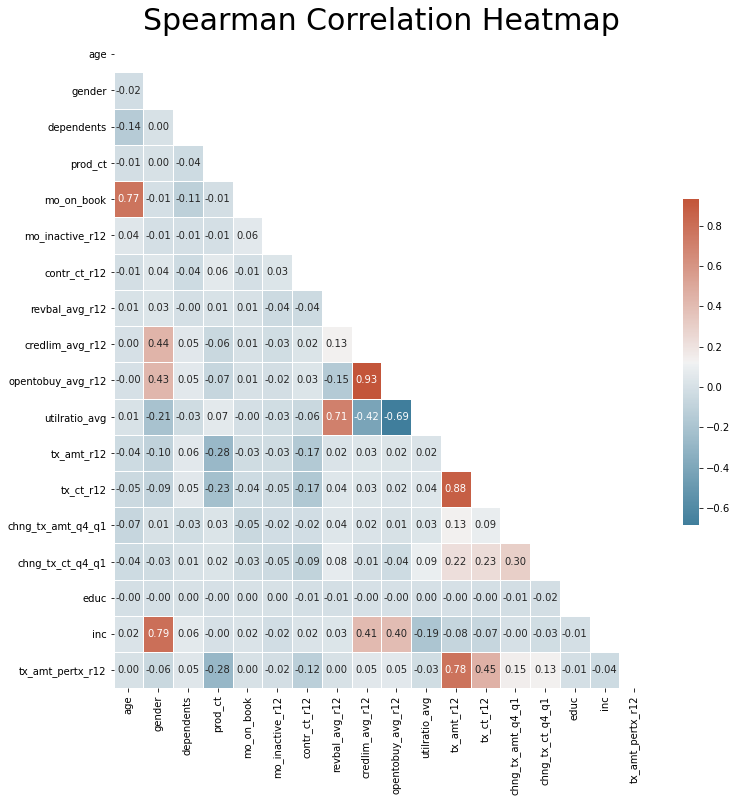

In [22]:
d_sample = d[['age', 'gender', 'dependents', 'prod_ct', 'mo_on_book',
       'mo_inactive_r12', 'contr_ct_r12', 'revbal_avg_r12', 'credlim_avg_r12',
       'opentobuy_avg_r12', 'utilratio_avg', 'tx_amt_r12', 'tx_ct_r12',
       'chng_tx_amt_q4_q1', 'chng_tx_ct_q4_q1', 'educ', 'inc',
       'tx_amt_pertx_r12']]
corr_map(d_sample, 'spearman')

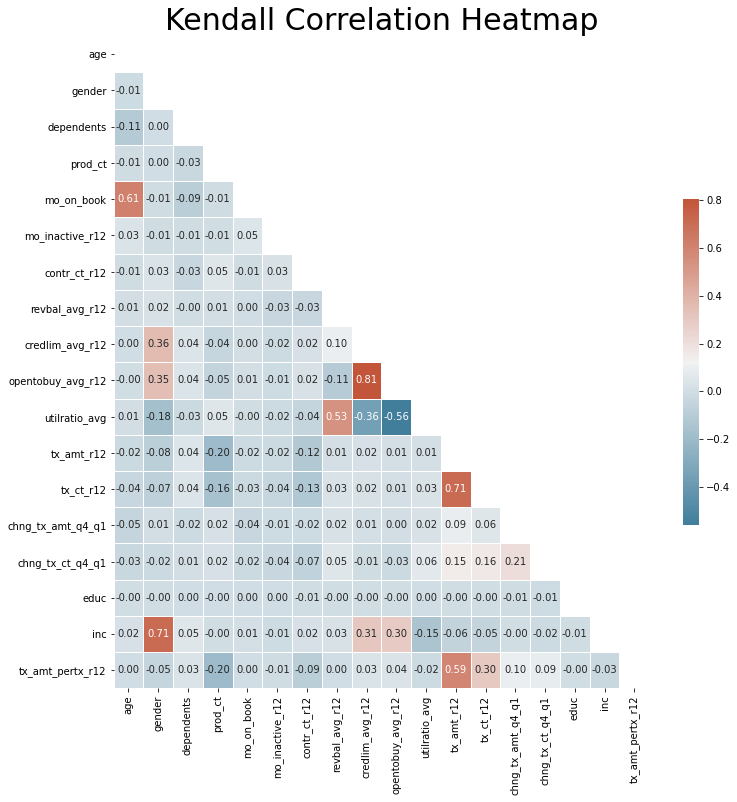

In [23]:
corr_map(d_sample, 'kendall')

In [24]:
def multicoll_ranked(d_sample, method, threshold=0.3):
    corr_abs = d_sample.rank().corr(method=method).abs()
    corr_pair = (corr_abs.where(
        np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
    corr_pair_filtered = corr_pair[(corr_pair!=1) & (corr_pair>threshold)].reset_index()
    corr_pair_filtered.columns = ['var1', 'var2', 'corr']
    print(method.title(), 'Correlation Pair')
    return(corr_pair_filtered)

In [25]:
multicoll_ranked_kendall = multicoll_ranked(d_sample, 'kendall')
multicoll_ranked_kendall

Kendall Correlation Pair


,var1,var2,corr
0,credlim_avg_r12,opentobuy_avg_r12,0.81
1,gender,inc,0.71
2,tx_amt_r12,tx_ct_r12,0.71
3,age,mo_on_book,0.61
4,tx_amt_r12,tx_amt_pertx_r12,0.59
5,opentobuy_avg_r12,utilratio_avg,0.56
6,revbal_avg_r12,utilratio_avg,0.53
7,gender,credlim_avg_r12,0.36
8,credlim_avg_r12,utilratio_avg,0.36
9,gender,opentobuy_avg_r12,0.35


In [26]:
multicoll_ranked_spearman = multicoll_ranked(d_sample, 'spearman')
multicoll_ranked_spearman

Spearman Correlation Pair


,var1,var2,corr
0,credlim_avg_r12,opentobuy_avg_r12,0.93
1,tx_amt_r12,tx_ct_r12,0.88
2,gender,inc,0.79
3,tx_amt_r12,tx_amt_pertx_r12,0.78
4,age,mo_on_book,0.77
5,revbal_avg_r12,utilratio_avg,0.71
6,opentobuy_avg_r12,utilratio_avg,0.69
7,tx_ct_r12,tx_amt_pertx_r12,0.45
8,gender,credlim_avg_r12,0.44
9,gender,opentobuy_avg_r12,0.43


<a id='4.2'>
    <h2 style='font-size:240%;'>
        Supervised</h2></a>

Supervised feature selection techniques consider the target variables in selecting the features that are the most important to predicting the target. These techniques can be used to remove irrelevant features.

A few ways in which we can use supervised feature selection techniques are:
1. Wrapper methods
2. Filter methods
3. Intrinsic methods

These methods are evaluated based on the resulting model's performance on a test set. 

**Wrapper feature selection methods** use different subsets of input variables to create multiple models and choose the feature combination that maximizes the model performance according to a metric. These methods are not sensitive to variable types but can be computationally expensive. RFE is one of the more common examples of a wrapper method.

**Filter feature selection methods** use statistical techniques to understand the relationship between the predictors and the target variable. Then, the resulting scores are used to filter out the input variables to be used in the model. Examples include statistical methods and feature importance methods. One must keep in mind that most of these techniques are univariate (predictors are evaluated in isolation one at a time) which may result in too many predictors and collinearity.

Finally, there are some algorithms that select features automatically as a part of learning the model. These techniques are referred to as **intrinsic feature selection methods**. These methods include penalized regression models such as Lasso and decision trees as well as ensembles of decision trees like random forest. 

We must note that some rule-based models such as the tree methods, MARS, and the lasso, are naturally resistant to non-informative predictors. 

An alternative to feature selection is a **dimensionality reduction method**. While these two are similar in that they both aim to reduce the number of features, they are different in that feature selection methods pick and choose which features to keep or remove whereas dimensionality reduction methods transform the input features entirely. 

[Source: Machine Learning Mastery - Feature Selection with Real & Categorical Data](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

For numerical predictors, we will be using the filter methods, ANOVA correlation coefficient (linear) and Kendall's rank coefficient (nonlinear). Kendall assumes categorical vaiables to be ordinal.

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Correlation Measures</h2></a>

Rank correlation can be calculated for real-valued variables. This is done by first converting the values for each variable into rank data. This is where the values are ordered and assigned an integer rank value. Rank correlation coefficients can then be calculated in order to quantify the association between the two ranked variables.

Because no distribution for the values is assumed, rank correlation methods are referred to as distribution-free correlation or nonparametric correlation. Interestingly, rank correlation measures are often used as the basis for other statistical hypothesis tests, such as determining whether two samples were likely drawn from the same (or different) population distributions.

[Source: Machine Learning Mastery - How to Calculate Nonparametric Rank Correlation in Python](https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/)

1. Spearman’s Rank Correlation
2. Kendall’s Rank Correlation
3. Chi-Squared Test

In [27]:
# null: the two variables are correlated
def sig_corr(d, corr_test, sig='sig'):
    
    # create a 3 lists of variable names, coefs, and p-values for every predictor-target pair
    l_var, l_coef, l_p = [],[],[]
    for i in d.columns:
        coef, p = corr_test(d[i], d['churn'])
        l_var.append(i)
        l_coef.append(round(coef,3))
        l_p.append(round(p,3))
    
    # make 2 df's: significant and insignificant variables
    df_all = pd.DataFrame(zip(l_var, l_coef, l_p), columns=['var','coef','p'])
    df_sig = df_all.loc[df_all['p']<=.05,:].sort_values(by='coef',ascending=False)[1:].reset_index(drop=True)
    df_insig = df_all.loc[df_all['p']>.05,:].sort_values(by='coef',ascending=False).reset_index(drop=True)
    
    # return the df of significant variables by default. If sig='insig', return the df of insignificant variables
    if sig=='insig':
        print(f'The following variables are likely NOT correlated to `churn`. We fail to reject H0:\n')
        return(df_insig)
    else:
        print(f'The following variables are likely correlated to `churn`. We can safely reject H0:\n')
        return(df_sig)

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Spearman's Rank Correlation</h2></a>

This statistical method quantifies the degree to which ranked variables are associated by a monotonic function, meaning an increasing or decreasing relationship. As a statistical hypothesis test, the method assumes that the samples are uncorrelated (fail to reject H0).

[Source: Machine Learning Mastery - How to Calculate Nonparametric Rank Correlation in Python](https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/)

In [28]:
print('Spearman Correlation Pair')
multicoll_ranked_spearman

Spearman Correlation Pair


,var1,var2,corr
0,credlim_avg_r12,opentobuy_avg_r12,0.93
1,tx_amt_r12,tx_ct_r12,0.88
2,gender,inc,0.79
3,tx_amt_r12,tx_amt_pertx_r12,0.78
4,age,mo_on_book,0.77
5,revbal_avg_r12,utilratio_avg,0.71
6,opentobuy_avg_r12,utilratio_avg,0.69
7,tx_ct_r12,tx_amt_pertx_r12,0.45
8,gender,credlim_avg_r12,0.44
9,gender,opentobuy_avg_r12,0.43


In [29]:
sig_spearman = sig_corr(d, spearmanr)
sig_spearman

The following variables are likely correlated to `churn`. We can safely reject H0:



,var,coef,p
0,contr_ct_r12,0.19,0.00
1,mo_inactive_r12,0.17,0.00
2,opentobuy_avg_r12,0.03,0.01
3,dependents,0.02,0.04
4,marstat_Married,-0.02,0.02
5,gender,-0.04,0.00
6,credlim_avg_r12,-0.05,0.00
7,chng_tx_amt_q4_q1,-0.10,0.00
8,prod_ct,-0.15,0.00
9,tx_amt_r12,-0.22,0.00


In [30]:
sig_spearman_abs = sig_spearman.copy()
sig_spearman_abs['coef'] = sig_spearman_abs['coef'].abs()

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Test w/ Spearman's Rank Correlation</h2></a>

Note: Kendall Tau's (below) also yielded the same columns.

In [31]:
var_to_keep = ['churn', 'tx_ct_r12', 'chng_tx_ct_q4_q1', 'revbal_avg_r12', 'contr_ct_r12', 'mo_inactive_r12', 'prod_ct', 
               'credlim_avg_r12', 'gender', 'marstat_Married','dependents']
d_values = d[var_to_keep].values
x, y = d_values[:,1:], d_values[:,:1].ravel()
results_trmt = summary_by_mod(x, y, models, scalers, result_func=result_rskf, n_splits=10, n_repeats=5)

Scaler: RS

Model LR Runtime: 00:01
Model LDA Runtime: 00:01
Model NB Runtime: 00:00
Model DT Runtime: 00:01
Model KNN Runtime: 00:26
Model MLP Runtime: 08:56
Model BDT Runtime: 00:31
Model RF Runtime: 00:12
Model GB Runtime: 00:25
Scaler RS Avg Runtime per Model: 01:10


Scaler: QT

Model LR Runtime: 00:01
Model LDA Runtime: 00:01
Model NB Runtime: 00:01
Model DT Runtime: 00:02
Model KNN Runtime: 00:28
Model MLP Runtime: 06:33
Model BDT Runtime: 00:30
Model RF Runtime: 00:12
Model GB Runtime: 00:27
Scaler QT Avg Runtime per Model: 00:55


Total Runtime: 18:58 min


In [32]:
results_trmt_RS = pd.concat([i for i in results_trmt[0]], axis=1)
results_trmt_QT = pd.concat([i for i in results_trmt[1]], axis=1)

<a id='4.2'>
    <h2 style='font-size:150%;'>
        Summary Comparison to Baseline</h2></a>

Dropping the variables didn't help at all. The models are worsened across all pipelines.

In [33]:
print('Results for Robust Scaler:')
tem = results_bsl_RS.loc[['test_recall', 'test_precision', 'test_f2']]
df_RS_bsl = tem.loc[:,np.in1d(tem.columns.get_level_values(1), 'mean')].droplevel(level=1, axis=1).rename(
    index={'test_recall':'recall', 'test_precision':'prec', 'test_f2':'f2'}).T

tem = results_trmt_RS.loc[['test_recall', 'test_precision', 'test_f2']]
df_RS_trmt = tem.loc[:,np.in1d(tem.columns.get_level_values(1), 'mean')].droplevel(level=1, axis=1).rename(
    index={'test_recall':'recall', 'test_precision':'prec', 'test_f2':'f2'}).T

comp_RS_kendall = pd.concat(
    [df_RS_bsl, df_RS_trmt], axis=1, 
    keys=['bsl','trmt']).reorder_levels(
    order=[1, 0], axis=1).reindex(
    ['recall', 'prec', 'f2'], level=0, axis=1)
comp_RS_kendall

Results for Robust Scaler:


recall      prec        f2     
       bsl trmt  bsl trmt  bsl trmt
LR    0.86 0.83 0.54 0.48 0.77 0.72
LDA   0.64 0.56 0.78 0.76 0.66 0.59
NB    0.60 0.57 0.68 0.77 0.62 0.60
DT    0.81 0.67 0.81 0.66 0.81 0.67
KNN   0.64 0.54 0.87 0.80 0.67 0.58
MLP   0.82 0.70 0.85 0.80 0.83 0.71
BDT   0.85 0.69 0.91 0.82 0.86 0.71
RF    0.81 0.67 0.93 0.86 0.83 0.70
GB    0.85 0.69 0.93 0.85 0.86 0.71

In [34]:
print('Results for Quantile Transformer:')
tem = results_bsl_QT.loc[['test_recall', 'test_precision', 'test_f2']]
df_QT_bsl = tem.loc[:,np.in1d(tem.columns.get_level_values(1), 'mean')].droplevel(level=1, axis=1).rename(
    index={'test_recall':'recall', 'test_precision':'prec', 'test_f2':'f2'}).T

tem = results_trmt_QT.loc[['test_recall', 'test_precision', 'test_f2']]
df_QT_trmt = tem.loc[:,np.in1d(tem.columns.get_level_values(1), 'mean')].droplevel(level=1, axis=1).rename(
    index={'test_recall':'recall', 'test_precision':'prec', 'test_f2':'f2'}).T

comp_QT_kendall = pd.concat(
    [df_QT_bsl, df_QT_trmt], axis=1, 
    keys=['bsl','trmt']).reorder_levels(
    order=[1, 0], axis=1).reindex(
    ['recall', 'prec', 'f2'], level=0, axis=1)
comp_QT_kendall

Results for Quantile Transformer:


recall      prec        f2     
       bsl trmt  bsl trmt  bsl trmt
LR    0.86 0.83 0.53 0.47 0.77 0.72
LDA   0.62 0.57 0.77 0.74 0.65 0.60
NB    0.61 0.61 0.63 0.71 0.61 0.63
DT    0.81 0.67 0.81 0.66 0.81 0.67
KNN   0.52 0.58 0.81 0.77 0.56 0.61
MLP   0.83 0.67 0.86 0.82 0.83 0.70
BDT   0.85 0.69 0.91 0.82 0.86 0.71
RF    0.81 0.67 0.93 0.86 0.83 0.70
GB    0.85 0.69 0.93 0.85 0.86 0.71

<a id='4.2'>
    <h2 style='font-size:150%;'>
        Full Comparison to Baseline</h2></a>

In [35]:
# results_results_trmt_RS

In [36]:
# results_results_trmt_QT

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Kendall's Tau</h2></a>

The intuition for the test is that it calculates a normalized score for the number of matching or concordant rankings between the two samples. As such, the test is also referred to as Kendall’s concordance test. As a statistical hypothesis test, the method assumes (H0) that there is no association between the two samples.

[Source: Machine Learning Mastery - How to Calculate Nonparametric Rank Correlation in Python](https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/)

In [37]:
print('Kendall Correlation Pair')
multicoll_ranked_kendall

Kendall Correlation Pair


,var1,var2,corr
0,credlim_avg_r12,opentobuy_avg_r12,0.81
1,gender,inc,0.71
2,tx_amt_r12,tx_ct_r12,0.71
3,age,mo_on_book,0.61
4,tx_amt_r12,tx_amt_pertx_r12,0.59
5,opentobuy_avg_r12,utilratio_avg,0.56
6,revbal_avg_r12,utilratio_avg,0.53
7,gender,credlim_avg_r12,0.36
8,credlim_avg_r12,utilratio_avg,0.36
9,gender,opentobuy_avg_r12,0.35


In [38]:
sig_kendall = sig_corr(d, kendalltau)
sig_kendall

The following variables are likely correlated to `churn`. We can safely reject H0:



,var,coef,p
0,contr_ct_r12,0.17,0.00
1,mo_inactive_r12,0.16,0.00
2,opentobuy_avg_r12,0.02,0.01
3,dependents,0.02,0.04
4,marstat_Married,-0.02,0.02
5,gender,-0.04,0.00
6,credlim_avg_r12,-0.04,0.00
7,chng_tx_amt_q4_q1,-0.08,0.00
8,prod_ct,-0.13,0.00
9,tx_amt_r12,-0.18,0.00


In [39]:
insig_kendall = sig_corr(d, kendalltau, 'insig')
insig_kendall

The following variables are likely NOT correlated to `churn`. We fail to reject H0:



,var,coef,p
0,marstat_Single,0.02,0.06
1,age,0.01,0.08
2,mo_on_book,0.01,0.12
3,card_Platinum,0.01,0.28
4,marstat_Unknown,0.01,0.37
5,educ,0.01,0.40
6,card_Gold,0.01,0.55
7,card_Blue,0.00,0.75
8,marstat_Divorced,0.00,0.93
9,tx_amt_pertx_r12,-0.01,0.50


In [40]:
print('Magnitude of impact in order:')
sig_kendall_abs = sig_kendall.copy()
sig_kendall_abs['coef'] = sig_kendall_abs['coef'].abs()
sig_kendall_abs.sort_values(by='coef', ascending=False).drop(['coef', 'p'], axis=1).reset_index(drop=True)

Magnitude of impact in order:


,var
0,tx_ct_r12
1,chng_tx_ct_q4_q1
2,revbal_avg_r12
3,utilratio_avg
4,tx_amt_r12
5,contr_ct_r12
6,mo_inactive_r12
7,prod_ct
8,chng_tx_amt_q4_q1
9,credlim_avg_r12


In [41]:
tem = all([i in ([*sig_spearman_abs['var']]) for i in [*sig_kendall_abs['var']]])
print(f'All variables in the Kendall selection are found in the Spearman selection: {tem}')
tem = all([i in ([*sig_kendall_abs['var']]) for i in [*sig_spearman_abs['var']]])
print(f'All variables in the Spearman selection are found in the Kendall selection: {tem}')

All variables in the Kendall selection are found in the Spearman selection: True
All variables in the Spearman selection are found in the Kendall selection: True


Since the vars are the same as the spearman's result we will skip fitting the models.

<a id='4.2'>
    <h2 style='font-size:180%;'>
        RFE</h2></a>

In [42]:
def summary_by_mod2(pred_mods, scalers, features, **n_splits_and_repeats):
    
    time_0 = time.time() # for all methods in pipeline
    
    results = []
    for scaler in scalers:
        time_1 = time.time() # for each scaler
        print(f'\nScaler: {scaler[0]}')
        
        results_features = []
        for feature in features:
            time_2 = time.time() # for each feature selection model
            print(f'\nFS Model: {feature[0]}')
            
            results_pred_mods = []
            for pred_mod in pred_mods:
                time_3 = time.time() # for each prediction model
                
                # define pipeline
                pipeline = Pipeline([('s', scaler[1]), ('fs', feature[1]), ('m', pred_mod[1])])

                # fit models
                n_splits, n_repeats = (i for i in n_splits_and_repeats.values())
                results_model = result_rskf(x, y, pipeline, pred_mod[0], n_splits, n_repeats)[0]
                
                # collect results - innermost
                print(f'Model {pred_mod[0]} Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-time_3))}')
                results_pred_mods.append(results_model)
            
            # collect results - middle
            print(f'FS Model {feature[0]} Avg Runtime per Model: {time.strftime("%M:%S", time.gmtime((time.time()-time_2)/len(pred_mods)))}\n\n')
            results_features.append(results_pred_mods)
        
        # collect results - outermost
        print(f'Scaler {scaler[0]} Avg Runtime per Model: {time.strftime("%M:%S", time.gmtime((time.time()-time_1)/len(features)))}\n\n')
        results.append(results_features)
        
    print(f'Total Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-time_0))} min')
    return results

In [43]:
# create a list of tuples for all models to explore: [(`model name`, `model instance`)] with minimum hyperparameter setting
models = []

# linear
models.append(('LR', LogisticRegression(solver='saga', max_iter=10000, class_weight='balanced', random_state=5))) # note: `max_iter` from 1000 to 10000 due to convergence issues
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))

# non-linear
models.append(('DT', DecisionTreeClassifier(random_state=5)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('MLP', MLPClassifier(max_iter=5000, random_state=5)))

# ensemble
models.append(('BDT', BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=5)))
models.append(('RF', RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=5))) # note: increasing n_estimators more than 400 doesn't do much; some in place to prevent too much overfitting
models.append(('GB', GradientBoostingClassifier(max_depth=10, random_state=5))) # note: `max_iter` from 100 to 1000 due to convergence issues

In [44]:
# create a list of tuples for all scalers to explore: [(`scaler name`, `scaler instance`)]
scalers = []
scalers.append(('RS', RobustScaler()))

In [45]:
# create a list of tuples for all feature selection/extraction models to explore: [(`fs name`, `fs instance`)]
features = []
features.append(('RFE', RFE(estimator=GradientBoostingClassifier(max_depth=10, random_state=5), n_features_to_select=20)))

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Validation Set</h2></a>

In [46]:
results_rfe = summary_by_mod2(models, scalers, features, n_splits=5, n_repeats=3)


Scaler: RS

FS Model: RFE

Prediction Model: LR
Model LR Runtime: 00:30

Prediction Model: LDA
Model LDA Runtime: 00:27

Prediction Model: NB
Model NB Runtime: 00:28

Prediction Model: DT
Model DT Runtime: 00:27

Prediction Model: KNN
Model KNN Runtime: 00:33

Prediction Model: MLP
Model MLP Runtime: 02:39

Prediction Model: BDT
Model BDT Runtime: 00:42

Prediction Model: RF
Model RF Runtime: 00:34

Prediction Model: GB
Model GB Runtime: 01:02
FS Model RFE Avg Runtime per Model: 00:49


Scaler RS Avg Runtime per Model: 07:25


Total Runtime: 07:25 min


In [47]:
results_rfe_RS = pd.concat([i for i in results_rfe[0][0]], axis=1)

<a id='4.2'>
    <h2 style='font-size:150%;'>
        Summary Treatment</h2></a>

Again, results are far worse than the baseline, but we may revisit after resampling.

In [48]:
print('Results for Robust Scaler:')
tem = results_rfe_RS.loc[['test_recall', 'test_precision', 'test_f2']]
df_RS_rfe_RS_summ = tem.loc[:,np.in1d(tem.columns.get_level_values(1), 'mean')].droplevel(level=1, axis=1).rename(
    index={'test_recall':'recall', 'test_precision':'prec', 'test_f2':'f2'}).T
df_RS_rfe_RS_summ

Results for Robust Scaler:


,recall,prec,f2
LR,0.83,0.48,0.72
LDA,0.56,0.76,0.59
NB,0.57,0.77,0.60
DT,0.68,0.66,0.67
KNN,0.54,0.80,0.58
MLP,0.69,0.80,0.71
BDT,0.69,0.82,0.72
RF,0.67,0.86,0.70
GB,0.70,0.82,0.72


<a id='6.2.5'>
    <h2 style='font-size:180%;'>
        Run Time Calculation
    </h2>
</a>

In [51]:
print(f'Notebook Total Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-start_normal))} min')

Notebook Total Runtime: 50:50 min


In [52]:
finish_normal = time.perf_counter()

In [53]:
print(f'Finished in {round(finish_normal-start_normal, 2)} second(s) or {round((finish_normal-start_normal)/60, 2)} minute(s).')

Finished in 2938.53 second(s) or 48.98 minute(s).


Some promising candidates are: RF, GB, and MLP with the current pipelline. This ranking may change with the addition of feature selection / extraction and possibly another outlier treatment.